In [1]:
#|default_exp augment

# Augmentation

In [2]:
#|export
import random
import fastcore.all as fc
from functools import partial

from datasets import load_dataset

import torch
from torch import distributions, nn, tensor, optim
from torch.nn import init
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy

from minai.conv import def_device
from minai.datasets import inplace, show_images, show_image
from minai.learner import MetricsCB, DeviceCB, ProgressCB, DataLoaders, Learner, TrainLearner, SingleBatchCB, MomentumLearner, lr_find, Callback, to_cpu
from minai.activations import Hooks
from minai.init import conv, GeneralRelu, init_weights, ActivationStats, set_seed, BatchTransformCB
from minai.sgd import BatchSchedCB
from minai.resnet import ResBlock

set_seed(42)

/home/studio-lab-user/.conda/envs/fastai/lib/python3.9/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.9.7) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [3]:
x1, y1 = 'image', 'label'
bs = 1024
ds = load_dataset('anubhavmaity/notMNIST')

In [4]:
@inplace
def transformi(b): b[x1] = [TF.to_tensor(o) for o in b[x1]]
dsd = ds.with_transform(transformi)

In [5]:
dls = DataLoaders.from_dd(dsd, batch_size=bs)

In [6]:
#|export
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)

In [7]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [8]:
lr, epochs = 6e-2, 5

## Going wider

In [9]:
def get_model(act=nn.ReLU, nfs=(16, 32, 64, 128, 256, 512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs) - 1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [10]:
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.881,0.609,0,True
0.615,1.737,0,False
0.911,0.373,1,True
0.761,1.089,1,False
0.919,0.313,2,True
0.939,0.249,2,False
0.951,0.195,3,True
0.948,0.189,3,False
0.967,0.142,4,True
0.948,0.191,4,False


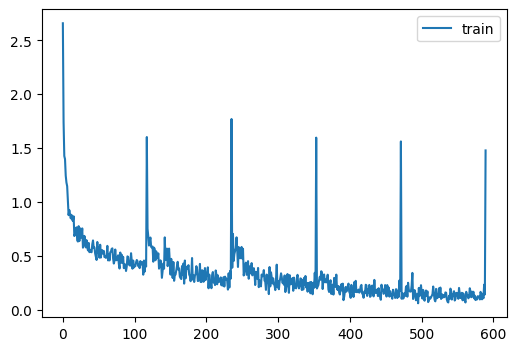

In [46]:
learn.fit(epochs)

## Pooling

In [11]:
class GlobalAvgPool(nn.Module):
    def forward(self, x): return x.mean((-2, -1))

In [12]:
def get_model2(act=nn.ReLU, nfs=(16, 32, 64, 128, 256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs) - 1)]
    layers += [ResBlock(256, 512, act=act, norm=norm), GlobalAvgPool()]
    layers += [nn.Linear(512, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [13]:
#|export
def _flops(x, h, w):
    if x.dim() < 3: return x.numel()
    if x.dim() == 4: return x.numel()*h*w
    raise Exception()

@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|MFlops|\n|--|--|--|--|--|\n'
    totp, totf = 0, 0
    def _f(hook, mod, inp, outp):
        nonlocal res,totp,totf
        nparams = sum(o.numel() for o in mod.parameters())
        totp += nparams
        *_,h,w = outp.shape
        flops = sum(_flops(o, h, w) for o in mod.parameters())/1e6
        totf += flops
        res += f'{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparams}|{flops:.1f}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, train=False, cbs=SingleBatchCB())
    print(f"Tot params: {totp}; MLFLOPS: {totf:.1f}")
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

In [ ]:
TrainLearner(get_model2(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

In [ ]:
set_seed(42)
model = get_model2(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [ ]:
def get_model3(act=nn.ReLU, nfs=(16, 32, 64, 128, 256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs) - 1)]
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [ ]:
TrainLearner(get_model3(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

In [ ]:
[o.shape for o in get_model3()[0].parameters()] # inside ResBlock

In [ ]:
set_seed(42)
model = get_model3(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [ ]:
def get_model4(act=nn.ReLU, nfs=(16, 32, 64, 128, 256), norm=nn.BatchNorm2d):
    layers = [conv(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs) - 1)]
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [ ]:
[o.shape for o in get_model4()[0].parameters()]

In [ ]:
TrainLearner(get_model4(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

In [ ]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

## Train for longer

In [ ]:
# set_seed(42)
# epochs = 20
# tmax = epochs * len(dls.train)
# sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
# xtra = [BatchSchedCB(sched)]
# model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
# learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
# learn.fit(epochs)

After 20 epochs without augmentation:

    Train:

        Accuracy: 0.999
        
        Loss: 0.030
    
    Valid:
    
        Accuracy: 0.955
        
        Loss: 0.184

## Data Augmentation

In [48]:
from torchvision import transforms

In [49]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y=fc.noop): return tfm_x(b[0]), tfm_y(b[1])

tfms = nn.Sequential(transforms.RandomCrop(28, padding=4), 
                     transforms.RandomRotation(10),
                    transforms.RandomAffine(0, translate=(0.1, 0.1)))
                    

augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[SingleBatchCB(), augcb, DeviceCB()])

[ResBlock(
  (convs): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
  (idconv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
  )
  (act): ReLU()
)]


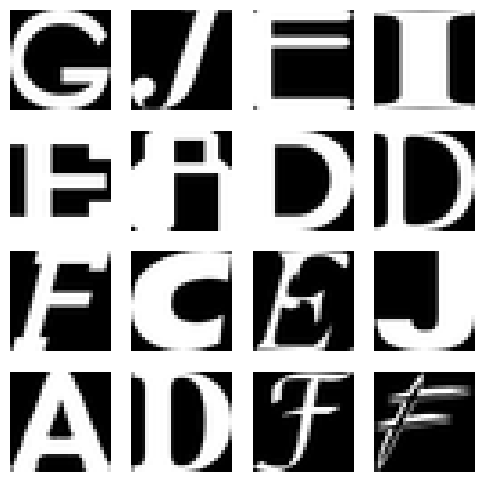

In [47]:
xb, yb = next(iter(dls.train))
show_images(xb[:16], imsize=1.5)

In [ ]:
learn.fit(1)

In [ ]:
xb, yb = learn.batch
show_images(xb[:16], imsize=1.5)

In [ ]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1), 
                     transforms.RandomRotation(10),
                     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))
                    )

augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [ ]:
set_seed(42)
epochs = 20
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

A custom collation function could let you do per-item transformations

In [ ]:
mdl_path = fc.Path('models')
mdl_path.mkdir(exist_ok=True)
torch.save(learn.model, mdl_path/'data_aug.pkl')

## TTA 
> Test Time Augmentation

In [ ]:
set_seed(42)
epochs = 20
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = torch.load(mdl_path/'data_aug.pkl')
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

In [ ]:
#|export
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_preds, self.all_targs = [], []
    def after_batch(self, learn):
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))

In [ ]:
cp = CapturePreds()
learn.fit(1, train=False, cbs=cp)

In [ ]:
cp2 = CapturePreds()
tfm_x= nn.Sequential(transforms.RandomRotation(10), transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)))
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=tfm_x), on_val=True)
learn.fit(1, train=False, cbs=[cp2, ttacb])

In [ ]:
ap1 = torch.cat(cp.all_preds)
ap2 = torch.cat(cp2.all_preds)
at = torch.cat(cp.all_targs)
ap1.shape, ap2.shape

In [ ]:
ap = torch.stack([ap1, ap2]).mean(0).argmax(1)

In [ ]:
round((ap==at).float().mean().item(), 3)

## Random Erase

In [ ]:
xb, _ = next(iter(dls.train))
xbt = xb[:16]

In [ ]:
show_images(xbt, imsize=1.5)

In [ ]:
xm, xs = xbt.mean(), xbt.std()
xm, xs

In [ ]:
xbt.min(), xbt.max()

In [ ]:
pct = 0.2

In [ ]:
szx = int(pct*xbt.shape[-2])
szy = int(pct*xbt.shape[-1])
stx = int(random.random() * (1 - pct) * xbt.shape[-2])
sty = int(random.random() * (1 - pct) * xbt.shape[-1])
stx, sty, szx, szy

In [ ]:
init.normal_(xbt[:, :, stx:stx+szx, sty:sty+szy], mean=xm, std=xs);

In [ ]:
show_images(xbt, imsize=1.5)

In [ ]:
xbt.min(), xbt.max()

In [ ]:
#|export
def _rand_erase(x, pct, xm, xs, mn, mx):
    szx = int(pct * x.shape[-2])
    szy = int(pct * x.shape[-1])
    stx = int(random.random() * (1 - pct) * x.shape[-2])
    sty = int(random.random() * (1 - pct) * x.shape[-1])
    init.normal_(x[:,:,stx:stx+szx, sty:sty+szy])
    x.clamp_(mn, mx)

In [ ]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
_rand_erase(xbt, 0.2, xbt.mean(), xbt.std(), xbt.min(), xbt.max())
show_images(xbt, imsize=1.5)

In [ ]:
xbt.mean(), xbt.std(), xbt.min(), xbt.max()

In [ ]:
#|export
def rand_erase(x, pct=0.2, max_num=4):
    xm, xs, mn, mx = x.mean(), x.std(), x.min(), x.max()
    num = random.randint(0, max_num)
    for i in range(num): _rand_erase(x, pct, xm, xs, mn, mx)
    return x

In [ ]:
xb, _ = next(iter(dls.train))
xbt = xb[:16]
rand_erase(xbt, 0.2, 4)
show_images(xbt, imsize=1.5)

In [ ]:
#|export
class RandErase(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct, self.max_num = pct, max_num
    def forward(self, x): return rand_erase(x, self.pct, self.max_num)

In [ ]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     RandErase())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [ ]:
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])
learn.fit(1)
xb, yb = learn.batch
show_images(xb[:16], imsize=1.5)

In [ ]:
epochs = 50
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [ ]:
cp = CapturePreds()
learn.fit(1, train=False, cbs=cp)

In [ ]:
mdl_path = fc.Path('models')
mdl_path.mkdir(exist_ok=True)
torch.save(learn.model, mdl_path/'random_erase.pkl')

## Random Copy

In [ ]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]

In [ ]:
szx = int(pct * xbt.shape[-2])
szy = int(pct * xbt.shape[-1])
stx1 = int(random.random() * (1 - pct) * xbt.shape[-2])
sty1 = int(random.random() * (1 - pct) * xbt.shape[-1])
stx2 = int(random.random() * (1 - pct) * xbt.shape[-2])
sty2 = int(random.random() * (1 - pct) * xbt.shape[-1])
stx1, sty1, stx2, sty2, szx, szy

In [ ]:
xbt[:, :, stx1:stx1+szx, sty1:sty1+szy] = xbt[:, :, stx2:stx2+szx, sty2:sty2+szy]

In [ ]:
show_images(xbt, imsize=1.5)

In [ ]:
random.random() * 28

In [ ]:
#|export
def _rand_copy1(x, pct):
    szx = int(pct * x.shape[-2])
    szy = int(pct * x.shape[-1])
    stx1 = int(random.random() * (1 - pct) * x.shape[-2])
    sty1 = int(random.random() * (1 - pct) * x.shape[-1])
    stx2 = int(random.random() * (1 - pct) * x.shape[-2])
    sty2 = int(random.random() * (1 - pct) * x.shape[-1])
    x[:, :, stx1:stx1+szx, sty1:sty1+szy] = x[:, :, stx2:stx2+szx, sty2:sty2+szy]

In [ ]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
_rand_copy1(xbt, 0.2)
show_images(xbt, imsize=1.5)

In [ ]:
#|export
def rand_copy(x, pct=0.2, max_num = 4):
    num = random.randint(0, max_num)
    for i in range(num): _rand_copy1(x, pct)
    return x

In [ ]:
xb, _ = next(iter(dls.train))
xbt = xb[:16]
rand_copy(xbt, 0.2, 4)
show_images(xbt, imsize=1.5)

In [ ]:
#|export
class RandCopy(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct, self.max_num = pct, max_num
    def forward(self, x): return rand_copy(x, self.pct, self.max_num)

In [ ]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     RandCopy())

In [ ]:
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [ ]:
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])
learn.fit(1)
xb, yb = learn.batch
show_images(xb[:16], imsize=1.5)

In [ ]:
set_seed(42)
epochs = 25
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [ ]:
model2 = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn2 = TrainLearner(model2, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn2.fit(epochs)

In [ ]:
mdl_path = fc.Path('models')
torch.save(learn.model, mdl_path/'randcopy1.pkl')
torch.save(learn2.model, mdl_path/'randcopy2.pkl')

In [ ]:
cp1 = CapturePreds()
learn.fit(1, train=False, cbs=cp1)

In [ ]:
cp2 = CapturePreds()
learn2.fit(1, train=False, cbs=cp2)

In [ ]:
ap1 = torch.cat(cp1.all_preds)
ap2 = torch.cat(cp2.all_preds)
at = torch.cat(cp1.all_targs)
ap1.shape, ap2.shape

In [ ]:
ap = torch.stack([ap1, ap2]).mean(0).argmax(1)

In [ ]:
round((ap==at).float().mean().item(), 3)

## Export

In [ ]:
import nbdev; nbdev.nbdev_export()

HW

- Create your own cosine annealing from scratch
- Create your own 1cycle scheduler from scratch
- Create your own Exponential Scheduler

All scheduler should work with Pytorch Optimizer and BatchScheduler


Beat JH on 5 epochs, 20 epochs & 50 epochs on Fashion MNIST using Minia

## Dropout

In [89]:
p = 0.1
dist = distributions.binomial.Binomial(probs=1-p)
dist.sample((10,))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 0.])

In [14]:
class Dropout(nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p
    def forward(self, x):
        if not self.training: return x
        dist = distributions.binomial.Binomial(tensor(1.0).to(x.device), probs=1-self.p)
        return x * dist.sample(x.size()) * 1/(1-self.p)    

In [108]:
def get_model(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d, drop=0.0):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [nn.Dropout2d(drop)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs) - 1)]
    layers += [nn.Flatten(), Dropout(drop), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [109]:
set_seed(42)
lr = 1e-2
epochs = 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d, drop=0.1).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

In [110]:
learn.summary()

Tot params: 4903556; MLFLOPS: 22.0


|Module|Input|Output|Num params|MFlops|
|--|--|--|--|--|
ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6864|5.3|
Dropout2d|(1024, 16, 28, 28)|(1024, 16, 28, 28)|0|0.0|
ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14432|2.8|
ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57536|2.8|
ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|229760|3.7|
ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|918272|3.7|
ResBlock|(1024, 256, 2, 2)|(1024, 512, 1, 1)|3671552|3.7|
Flatten|(1024, 512, 1, 1)|(1024, 512)|0|0.0|
Dropout|(1024, 512)|(1024, 512)|0|0.0|
Linear|(1024, 512)|(1024, 10)|5120|0.0|
BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


accuracy,loss,epoch,train
0.764,1.019,0,True
0.904,0.343,0,False
0.917,0.472,1,True
0.934,0.239,1,False
0.945,0.325,2,True
0.943,0.281,2,False
0.962,0.249,3,True
0.953,0.257,3,False
0.972,0.209,4,True
0.951,0.277,4,False


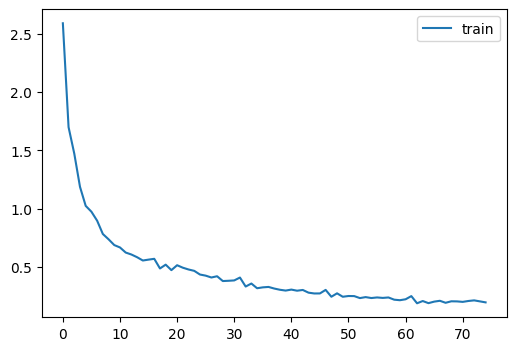

In [111]:
learn.fit(epochs)

> Exercise: Implement Dropout2d from scratch

In [23]:
class TTD_CB(Callback):
    def before_epoch(self, learn):
        learn.model.apply(lambda m: m.train() if isinstance(m, (nn.Dropout, nn.Dropout2d)) else None)

In [54]:
dist = distributions.binomial.Binomial(tensor(1.0), probs=0.1)
d = dist.sample((1, 16, 1, 1))
d

tensor([[[[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[1.]]]])

In [121]:
class Dropout2D(nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p
    def forward(self, x):
        if not self.training: return x
        dist = distributions.binomial.Binomial(tensor(1.0).to(x.device), probs=1-self.p)
        _, f, *_ = x.size() 
        return x * dist.sample((1, f, 1, 1)) * 1.0/(1-self.p)

In [134]:
def get_model(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d, drop=0.0):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [Dropout2D(drop)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs) - 1)]
    layers += [nn.Flatten(), Dropout(drop), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [135]:
set_seed(42)
lr = 1e-2
epochs = 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d, drop=0.1).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

In [136]:
learn.summary()

Tot params: 4903556; MLFLOPS: 22.0


|Module|Input|Output|Num params|MFlops|
|--|--|--|--|--|
ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6864|5.3|
Dropout2D|(1024, 16, 28, 28)|(1024, 16, 28, 28)|0|0.0|
ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14432|2.8|
ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57536|2.8|
ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|229760|3.7|
ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|918272|3.7|
ResBlock|(1024, 256, 2, 2)|(1024, 512, 1, 1)|3671552|3.7|
Flatten|(1024, 512, 1, 1)|(1024, 512)|0|0.0|
Dropout|(1024, 512)|(1024, 512)|0|0.0|
Linear|(1024, 512)|(1024, 10)|5120|0.0|
BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


accuracy,loss,epoch,train
0.762,1.023,0,True
0.851,0.562,0,False
0.894,0.552,1,True
0.915,0.307,1,False
0.932,0.371,2,True
0.937,0.277,2,False
0.947,0.295,3,True
0.939,0.349,3,False
0.959,0.250,4,True
0.943,0.273,4,False


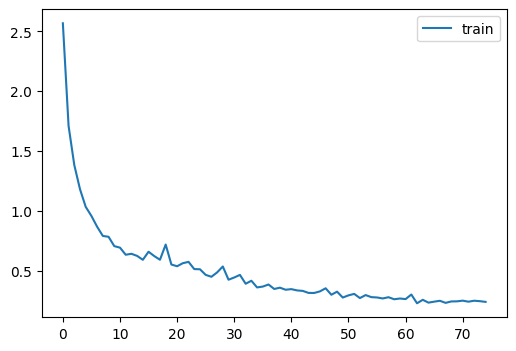

In [137]:
learn.fit(epochs)